<a href="https://colab.research.google.com/github/Geerford/data-science-ipynb/blob/master/Reinforcement%20learning/Reinforement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение необходимых библиотек

In [ ]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

Параметры

In [ ]:
epsilon = 0.1 # Параметр ε-жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования
random_seed = 2020
learning_rate = 0.9
map_size = 6
frozen_prob = 0.8
total_games = 30000
max_steps = 100

Поиск в глубину (Depth-first search). Проверка пути

In [ ]:
def is_valid(res, size):
  frontier, discovered = [], set()
  frontier.append((0,0))
  while frontier:
    r, c = frontier.pop()
    if not (r,c) in discovered:
      discovered.add((r,c))
      directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
      for x, y in directions:
        r_new = r + x
        c_new = c + y
        if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
            continue
        if res[r_new][c_new] == 'G':
            return True
        if (res[r_new][c_new] not in '#H'):
              frontier.append((r_new, c_new))
  return False

Генерация карты. 
Параметр *p* - вероятность льдистой ячейки.
Параметр *is_slippery* - скольжение.
*   *S* - старт
*   *F* - лед (безопасная ячейка)
*   *H* - проталина (нет пути)
*   *G* - цель

In [ ]:
def generate_random_map(size, p):
  np.random.seed(random_seed)
  valid = False
  while not valid:
    p = min(1, p)
    res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
    res[0][0] = 'S'
    res[-1][-1] = 'G'
    valid = is_valid(res, size)
  return [''.join(x) for x in res]

random_map = generate_random_map(size=map_size, p=frozen_prob) #Генерация карты
env = gym.make('FrozenLake-v0', desc=random_map, is_slippery=False) #Инициализируем среду
env.render()


SHFFFF
FFHFFF
FFFFFF
FFHFFH
FFFFFF
FHFFHG


Выбор действия, алгоритмы обучения



In [ ]:
def choose_action(state, Q):
  action = 0
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()
  else:
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
  return action

def q_learn(state, state2, reward, action, done, Q):
  if done:
    Q[state, action] += learning_rate * (reward - Q[state, action])
  else:
    Q[state, action] += learning_rate * (reward + gamma * np.max(Q[state2]) - Q[state, action])
  return Q

def sarsa_learn(state, state2, reward, action, action2, done, Q):
  if done:
    Q[state, action] += learning_rate * (reward - Q[state, action])
  else:
    Q[state, action] += learning_rate * (reward + gamma * Q[state2, action2] - Q[state, action])
  return Q

Q-обучение и SARSA-алгоритм

In [ ]:
def q_simulate(total_games, max_steps):
  np.random.seed(random_seed)
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  win = 0
  win_streaks = []
  for game in tqdm(range(total_games)):
    state = env.reset()
    step = 0
    while step < max_steps:
      step += 1
      action = choose_action(state, Q)
      state2, reward, done, info = env.step(action)
      if step == max_steps:
        done = True  
      Q = q_learn(state, state2, reward, action, done, Q)
      state = state2
      if done:
        if reward == 1:
          win += 1
        else:
          if win > 0:
            win_streaks.append(win)
          win = 0
        break
  return Q, win, win_streaks

def sarsa_simulate(total_games, max_steps):
  np.random.seed(random_seed)
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  win = 0
  win_streaks = []
  for game in tqdm(range(total_games)):
    state = env.reset()
    step = 0
    action = choose_action(state, Q) # Выбор действия в начале каждой игры
    while step < max_steps:
      step += 1      
      state2, reward, done, info = env.step(action)
      action2 = choose_action(state2, Q) # Выбор действия для следующего шага игры и для обновления ценности совершенного действия
      if step == max_steps:
        done = True  
      Q = sarsa_learn(state, state2, reward, action, action2, done, Q)
      state = state2
      action = action2
      if done:
        if reward == 1:
          win += 1
        else:
          if win > 0:
            win_streaks.append(win)
          win = 0
        break
  return Q, win, win_streaks

Получение состояний одной игры. Применяется жадный выбор действий, при учете обученной модели

In [ ]:
def choose_action_one_game(state, Q):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def get_state(Q):
  states = []
  step = 0
  state = env.reset()
  while(step < max_steps):
    env.render()
    time.sleep(0.1)
    clear_output(wait=True)
    action = choose_action_one_game(state, Q)  
    state2, reward, done, info = env.step(action)  
    states.append(state)
    state = state2
    step += 1
    if done and reward == 1:
      states.append(state)
    if done:
      break
  return states

Отрисовка маршрута игры

In [ ]:
def make_maze_pic(maze):
  maze_pic = []
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(1)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  
def plot_path(states):
  maze_pic = make_maze_pic(random_map)
  nrows, ncols = maze_pic.shape
  rw = np.remainder(states, nrows)
  cl = np.floor_divide(states, nrows)

  # Отрисовка пути
  fig, ax1 = plt.subplots(1, 1, tight_layout=True)
  ax1.clear()
  ax1.set_xticks(np.arange(0.5, nrows, step=1))
  ax1.set_xticklabels([])
  ax1.set_yticks(np.arange(0.5, ncols, step=1))
  ax1.set_yticklabels([])
  ax1.grid(True)
  ax1.plot([0], [0], 'gs', markersize=40)
  ax1.text(0, 0.2, 'Start', ha='center', va='center', color='white', fontsize=12)
  ax1.plot([nrows-1], [ncols-1], 'rs', markersize=40)
  ax1.text(nrows-1, ncols-1+0.2,'Finish', ha='center', va='center', color='white', fontsize=12)
  ax1.plot(rw, cl, ls='-', color='blue')
  ax1.plot(rw, cl, 'bo')
  ax1.imshow(maze_pic, cmap='binary')

Симуляция Q-обучения

Количество побед в серии из 30000 игр: 21924
Самый большой вин-стрик: 46
Симуляция игры после обучения


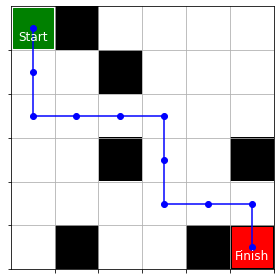

In [ ]:
Q, win, win_streaks = q_simulate(total_games, max_steps)
plot_path(get_state(Q))
print('Количество побед в серии из {} игр: {}'.format(total_games, sum(win_streaks)))
print('Самый большой вин-стрик: {}'.format(max(win_streaks)))
print('Симуляция игры после обучения')

Симуляция SARSA-алгоритма

Количество побед в серии из 30000 игр: 19907
Самый большой вин-стрик: 53
Симуляция игры после обучения


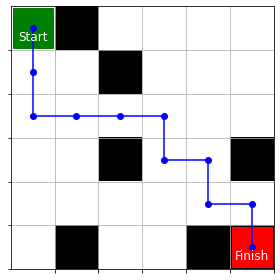

In [ ]:
Q, win, win_streaks = sarsa_simulate(total_games, max_steps)
plot_path(get_state(Q))
print('Количество побед в серии из {} игр: {}'.format(total_games, sum(win_streaks)))
print('Самый большой вин-стрик: {}'.format(max(win_streaks)))
print('Симуляция игры после обучения')